In [1371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Read the csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Title

First thing we notice is that each passenger seems to have a title in his name. It will be relevant as more priviledged social classes were prioritized. The format it follows is a space before and a period after the title. We will leverage this using a regex to create a new feature.

How many passengers do not have a title ? :  0
How many passengers do not have a title ? :  0


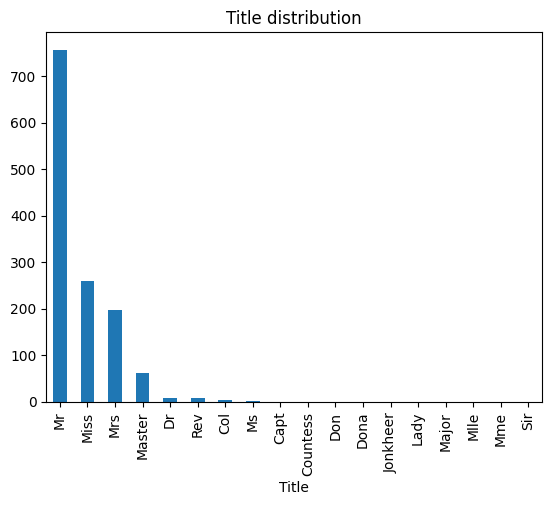

In [1372]:
#Create a new column 'Title' based on the 'Name'
def clean_title(data):
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    print('How many passengers do not have a title ? : ',data['Title'].isna().sum())
    
    return data

train = clean_title(train)
test = clean_title(test)

unique_values = train.groupby('Title')['Title'].count() + test.groupby('Title')['Title'].count()
unique_values.sort_values(ascending=False).plot(kind='bar',x='Title',y='Count',title='Title distribution')
plt.show()

In [1373]:
#Let's map the titles to a numerical value, all the non-relevant titles will be grouped as 4

title_mapping = {
    'Mr': 0,
    'Mrs': 1,
    'Miss': 2,
    'Master': 3
}

def map_title(data,title_mapping):
    data['Title'] = data['Title'].map(title_mapping).fillna(4).astype('category')
    return data

train = map_title(train,title_mapping)
test = map_title(test,title_mapping)


# Sex

Let's leverage the sex as it is famously known that women were priotized over men.

In [1374]:
#Numerize the 'Sex' column
def replace_sex(data):   
    data['Sex'] = data['Sex'].replace({'male': 0, 'female': 1}).astype('category')
    return data

train = replace_sex(train)
test = replace_sex(test)


# Fare
The amount of money spent on the ticket is important as it adds to the economic status of the passenger, which will definitely influence his survival rate.

How many missing values in the 'Fare' train column ? :  0
How many missing values in the 'Fare' test column ? :  1


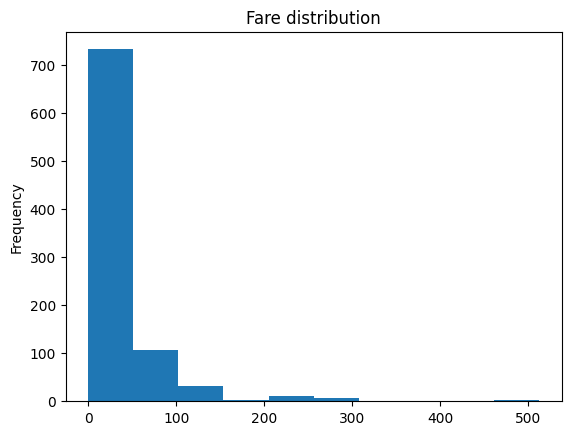

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [1375]:
print("How many missing values in the 'Fare' train column ? : ",train['Fare'].isna().sum())
print("How many missing values in the 'Fare' test column ? : ",test['Fare'].isna().sum())

#Plot the 'Fare' column
train['Fare'].plot(kind='hist',title='Fare distribution')
plt.show()

print(train['Fare'].describe())


In [1376]:
#Filling the empty Fare values based on the median value as there's only 1 missing value in the test set

def fill_fare(data):
    data['Fare'] = data.groupby(['Title','Pclass'])['Fare'].transform(lambda x: x.fillna(x.median())).astype(int)
    data['Fare'] = pd.qcut(data['Fare'],4).cat.codes
    return data

train = fill_fare(train)
test = fill_fare(test)

C:\Users\noahg\AppData\Local\Temp\ipykernel_19016\468091382.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Fare'] = data.groupby(['Title','Pclass'])['Fare'].transform(lambda x: x.fillna(x.median())).astype(int)
C:\Users\noahg\AppData\Local\Temp\ipykernel_19016\468091382.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Fare'] = data.groupby(['Title','Pclass'])['Fare'].transform(lambda x: x.fillna(x.median())).astype(int)


# Age

Once again age is an important feature as children were given priority over adults.

In [1377]:
print("How many missing values in the 'Age' column ? in the train set: ",train['Age'].isna().sum())
print("How many missing values in the 'Age' column ? in the test set: ",test['Age'].isna().sum())

#Several passengers are missing the 'Age' value, let's try a way to fill them.
#Filling the empty Age values based on the median value of its combination of Title & Fare categories

combined = pd.concat([train, test], ignore_index=True)

train['Age'] = train['Age'].fillna(combined.groupby(['Title','Pclass'])['Age'].transform('median')).astype(int) 
test['Age'] = test['Age'].fillna(combined.groupby(['Title','Pclass'])['Age'].transform('median')).astype(int)

#Discretizing the age into 4 categories of my own choice
#If age is between 0 and 14 it's 0, between 14 and 18 it's 1, between 18 and 25 it's 2, between 25 and 50 it's 3 and over 50 it's 4
# Define the age bins and labels
age_bins = [0, 10,100]
age_labels = [0, 1]

# Apply pd.cut with the specified labels
train['Age'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels, right=False)
test['Age'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels, right=False)

train['Age'] = train['Age'].cat.codes
test['Age'] = test['Age'].cat.codes

How many missing values in the 'Age' column ? in the train set:  177
How many missing values in the 'Age' column ? in the test set:  86


C:\Users\noahg\AppData\Local\Temp\ipykernel_19016\3596680402.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train['Age'] = train['Age'].fillna(combined.groupby(['Title','Pclass'])['Age'].transform('median')).astype(int)
C:\Users\noahg\AppData\Local\Temp\ipykernel_19016\3596680402.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test['Age'] = test['Age'].fillna(combined.groupby(['Title','Pclass'])['Age'].transform('median')).astype(int)


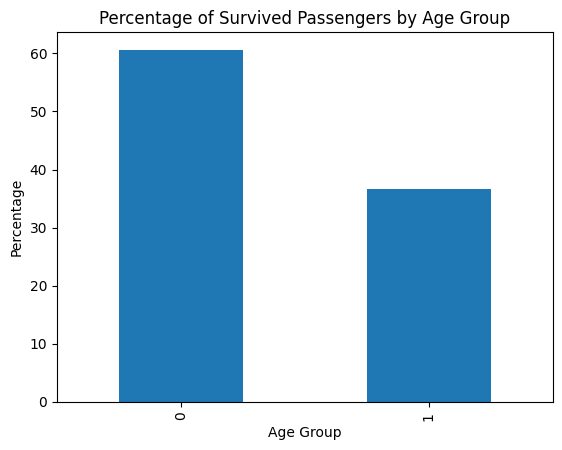

In [1378]:
import matplotlib.pyplot as plt


# Group by 'AgeGroup' and calculate the count of survived passengers
survived_counts = train[train['Survived'] == 1].groupby('Age')['Age'].count()

# Group by 'AgeGroup' and calculate the total number of passengers
total_counts = train.groupby('Age')['Age'].count()

# Calculate the percentage of survived passengers for each age group
survived_percentage = (survived_counts / total_counts) * 100

# Plot the results
survived_percentage.plot(kind='bar', title='Percentage of Survived Passengers by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.show()


In [1379]:
#Filling missing Embarked values with most frequent value and then numerize them
S = train['Embarked'].value_counts()

train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

train['Embarked'] = train['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
test['Embarked'] = test['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})

In [1380]:
#Fusing SibSp and Parch into Fam, 0 if alone and 1 if with family

train['Fam'] = (train['SibSp'] + train['Parch']).apply(lambda x: 1 if x > 0 else 0)
test['Fam'] = (test['SibSp'] + test['Parch']).apply(lambda x: 1 if x > 0 else 0)

"""

train['SibSp'] = train['SibSp'].apply(lambda x: 1 if x > 0 else 0).astype('category')
test['SibSp'] = test['SibSp'].apply(lambda x: 1 if x > 0 else 0).astype('category')

train['Parch'] = train['Parch'].apply(lambda x: 1 if x > 0 else 0).astype('category')
test['Parch'] = test['Parch'].apply(lambda x: 1 if x > 0 else 0).astype('category')

"""
train.drop(['Name','Ticket','Cabin','PassengerId','SibSp','Parch'],axis=1,inplace=True)
test.drop(['Name','Ticket','Cabin','SibSp','Parch'],axis=1,inplace=True)
#Split the data into x and y
x_train = train.drop('Survived', axis=1)
y_train = train['Survived']


train.corr()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Fam
Survived,1.000000,-0.338481,0.543351,-0.129244,0.301792,0.106811,0.410593,0.203367
Pclass,-0.338481,1.000000,-0.131900,-0.116059,-0.660699,0.045702,-0.130404,-0.135207
Sex,0.543351,-0.131900,1.000000,-0.060469,0.237585,0.116569,0.567187,0.303646
Age,-0.129244,-0.116059,-0.060469,1.000000,-0.164291,0.032728,-0.449706,-0.339604
Fare,0.301792,-0.660699,0.237585,-0.164291,1.000000,-0.080190,0.259017,0.546027
Embarked,0.106811,0.045702,0.116569,0.032728,-0.080190,1.000000,0.124053,-0.017807
Title,0.410593,-0.130404,0.567187,-0.449706,0.259017,0.124053,1.000000,0.276800
Fam,0.203367,-0.135207,0.303646,-0.339604,0.546027,-0.017807,0.276800,1.000000


In [1381]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score

def f1_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()  # True labels
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    return f1_score(y_true, y_pred_binary)
"""
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators' : [1500, 2000, 2500],
    'objective': ['binary:logistic'],
    
}


xgb = XGBClassifier(seed=27,enable_categorical=True)

# Initialize GridSearchCV
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)

# Fit the model
grid.fit(x_train, y_train)

# Get the best parameters
print(grid.best_params_)
print(grid.best_score_)

"""
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,objective='binary:logistic',
                                max_depth=3, min_child_weight=0,enable_categorical=True,
                                gamma=0, subsample=0.9,
                                colsample_bytree=0.8,seed=27,
                                reg_alpha=0.00006)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1382]:
pred = model.predict(test.drop('PassengerId', axis=1))
threshold = 0.5

predicted_classes = (pred >= threshold).astype(int)

submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predicted_classes.reshape(-1)})
submission.to_csv('submission1.csv', index=False)

In [1383]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Define parameter grid
param_grid = {
    'n_estimators': [2000, 2250, 2500, 2750],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'max_depth': [2, 3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [0, 1, 3, 5, 7],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Initialize classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    scoring='accuracy',  # Use a scoring metric
    cv=5,  # Cross-validation folds
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit to data
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))


NameError: name 'X_train' is not defined

In [735]:

#Create a new column 'Title' based on the 'Name'
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

#Map the most frequent titles to numbers
unique_values = train.groupby('Title')['Title'].count().sort_values(ascending=False)
title_mapping = {
    'Mr': 0,
    'Mrs': 1,
    'Miss': 2,
    'Master': 3
}

#Transform the new column 'Title' based on the mapping, other titles will be grouped as 4
train['Title'] = train['Title'].map(title_mapping).fillna(4).astype('category')
test['Title'] = test['Title'].map(title_mapping).fillna(4).astype('category')

#Drop the columns that are not needed anymore
train = train.drop(['PassengerId','Ticket','Name'], axis=1)
test = test.drop(['Ticket','Name'], axis=1)

#Numerize the 'Sex' column
train['Sex'] = train['Sex'].replace({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].replace({'male': 0, 'female': 1})

#Filling missing Cabin values, if there is a cabin number, it will be 1, otherwise 0
train['Cabin'] = np.where(train['Cabin'].isna(), 0, 1)
test['Cabin'] = np.where(test['Cabin'].isna(), 0, 1)

#Filling missing Embarked values with most frequent value and then numerize them
S = train['Embarked'].value_counts()

train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

train['Embarked'] = train['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
test['Embarked'] = test['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})

#Filling the empty Age values based on the median value

train['Age'] = train['Age'].fillna(train['Age'].median()).astype(int)
test['Age'] = test['Age'].fillna(test['Age'].median()).astype(int)


#Discretizing the age into 4 categories
age = train['Age'].describe()

train['Age'] = pd.cut(train['Age'],4)
test['Age'] = pd.cut(test['Age'], 4)

train['Age'] = train['Age'].cat.codes
test['Age'] = test['Age'].cat.codes

#Discretizing the fare into 4 categories
fare = train['Fare'].describe()

train['Fare'] = pd.qcut(train['Fare'],4)
test['Fare'] = pd.qcut(test['Fare'], 4)

train['Fare'] = train['Fare'].cat.codes
test['Fare'] = test['Fare'].cat.codes

#Fusing SibSp and Parch into Fam, 0 if alone and 1 if with family
train['Fam'] = (train['SibSp'] + train['Parch']).apply(lambda x: 1 if x > 0 else 0)
test['Fam'] = (test['SibSp'] + test['Parch']).apply(lambda x: 1 if x > 0 else 0)

#Drop the now useless columns
train = train.drop(['SibSp','Parch'], axis=1)
test = test.drop(['SibSp','Parch'], axis=1)

#Split the data into x and y
x_train = train.drop('Survived', axis=1)
y_train = train['Survived']

corr2 = train.corr()
corr2

KeyError: 'Name'